# Exploratory: relationship between votes and seats

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Do-primary-votes-for-Others-follow-the-cube-rule?" data-toc-modified-id="Do-primary-votes-for-Others-follow-the-cube-rule?-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Do primary votes for Others follow the cube rule?</a></span></li><li><span><a href="#Cube-rule-and-2pp-vs-seats-won-by-major-parties-only-(ie.-ignoring-other-seats-won)" data-toc-modified-id="Cube-rule-and-2pp-vs-seats-won-by-major-parties-only-(ie.-ignoring-other-seats-won)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cube rule and 2pp vs seats won by major parties only (ie. ignoring other seats won)</a></span></li><li><span><a href="#2pp-margin-vs-seat-margin" data-toc-modified-id="2pp-margin-vs-seat-margin-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>2pp margin vs seat margin</a></span></li></ul></div>

## Python setup

In [1]:
# Analytic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import bs4
import statsmodels.api as sm

# System imports
import platform, pathlib
from io import StringIO

In [2]:
print(f'python { platform.python_version()}')
print(f'numpy {np.__version__}')
print(f'pandas {pd.__version__}')
print(f'matplotlib {mpl.__version__}')
print(f'requests {requests.__version__}')
print(f'bs4 {bs4.__version__}')
print(f'statsmodels {sm.__version__}')


python 3.9.7
numpy 1.21.4
pandas 1.3.4
matplotlib 3.4.3
requests 2.26.0
bs4 4.10.0
statsmodels 0.13.0


In [3]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')

CHART_DIR = '../charts'
pathlib.Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
CHART_DIR += '/'

## Get the data

In [4]:
def get_wiki_page():
    WIKIURL = 'https://en.wikipedia.org/wiki/List_of_Australian_federal_elections'
    response = requests.get(WIKIURL)
    assert(response.status_code == 200) # successful retrieval
    return response.text
    
text = get_wiki_page()
source = 'Election data sourced from Wikipedia'

In [5]:
# get data into a DataFrame
HISTORY_TABLE = 2
soup = bs4.BeautifulSoup(text)
tables = soup.findAll('table')
html = str(tables[HISTORY_TABLE])
df = pd.read_html(html, flavor='bs4', na_values='–')[0]
df = df.dropna(axis=0, how='any')

# fix the date column to a pandas Timestamp
for i, name in enumerate(['Date', '']):
    # kludge for df.rename() not working with multi-indexes
    df.rename(columns={(df.columns[0])[i]: (name),}, level=i, inplace=True)
df['Date'] = df['Date'].str.replace(' election', '').str.strip()
df['Date'] = pd.to_datetime(df['Date'])


# fix percentages - make numerical columns a numerical dtype
for c in df.select_dtypes(include=['string','object']).columns:
    df[c] = df[c].str.replace('%', '').astype(float) / 100.0
    
# make date the index
df = df.set_index('Date', )
df.tail()

Primary vote               2PP vote        Seats                  
                    ALP   L+NP   Oth.      ALP   L+NP   ALP  L+NP Oth.  Total
Date                                                                         
2007-11-24        0.434  0.421  0.145    0.527  0.473  83.0  65.0  2.0  150.0
2010-08-21        0.380  0.433  0.187    0.501  0.499  72.0  72.0  6.0  150.0
2013-09-07        0.334  0.456  0.210    0.465  0.535  55.0  90.0  5.0  150.0
2016-07-02        0.347  0.420  0.233    0.496  0.504  69.0  76.0  5.0  150.0
2019-05-18        0.333  0.414  0.253    0.485  0.515  68.0  77.0  6.0  151.0

In [6]:
# Augment this DataFrame wih information about government at election

govt_at_election = """
Date, Governing Party at election, Governing since, PM at election, Winning party, Notes
1919-12-13, L+NP, 1917-02-17, Hughes,   L+NP, 
1922-12-16, L+NP, 1917-02-17, Hughes,   L+NP,
1925-11-14, L+NP, 1917-02-17, Bruce,    L+NP,
1928-11-17, L+NP, 1917-02-17, Bruce,    L+NP,
1929-10-12, L+NP, 1917-02-17, Bruce,    ALP,
1931-12-19,  ALP, 1929-10-22, Scullin,  L+NP,
1934-09-15, L+NP, 1932-01-06, Lyons,    L+NP,
1937-10-23, L+NP, 1932-01-06, Lyons,    L+NP
1940-09-21, L+NP, 1932-01-06, Menzies,  L+NP,  
1943-08-21,  ALP, 1941-10-07, Curtin,   ALP,  Change of Govt. during term prior to electon
1946-09-28,  ALP, 1941-10-07, Chifley,  ALP,
1949-12-10,  ALP, 1941-10-07, Chifley,  L+NP,
1951-04-28, L+NP, 1949-12-19, Menzies,  L+NP,
1954-05-29, L+NP, 1949-12-19, Menzies,  L+NP,
1955-12-10, L+NP, 1949-12-19, Menzies,  L+NP,
1958-11-22, L+NP, 1949-12-19, Menzies,  L+NP,
1961-12-09, L+NP, 1949-12-19, Menzies,  L+NP,
1963-11-30, L+NP, 1949-12-19, Menzies,  L+NP,
1966-11-26, L+NP, 1949-12-19, Holt,     L+NP,
1969-10-25, L+NP, 1949-12-19, Gorton,   L+NP,
1972-12-02, L+NP, 1949-12-19, McMahon,  ALP,
1974-05-18,  ALP, 1972-12-05, Whitlam,  ALP,
1975-12-13, L+NP, 1975-11-11, Fraser,   L+NP, Fraser became Caretaker PM prior to election
1977-12-10, L+NP, 1975-11-11, Fraser,   L+NP,
1980-10-18, L+NP, 1975-11-11, Fraser,   L+NP, 
1983-03-05, L+NP, 1975-11-11, Fraser,   ALP,
1984-12-01,  ALP, 1983-03-11, Hawke,    ALP,
1987-07-11,  ALP, 1983-03-11, Hawke,    ALP,
1990-03-24,  ALP, 1983-03-11, Hawke,    ALP, 
1993-03-13,  ALP, 1983-03-11, Keating,  ALP,
1996-03-02,  ALP, 1983-03-11, Keating,  L+NP,
1998-10-03, L+NP, 1996-03-11, Howard,   L+NP,
2001-11-10, L+NP, 1996-03-11, Howard,   L+NP,
2004-10-09, L+NP, 1996-03-11, Howard,   L+NP,
2007-11-24, L+NP, 1996-03-11, Howard,   ALP,
2010-08-21,  ALP, 2007-12-03, Gillard,  ALP,  Outcome was tied major party seats; Govt. decided by independents
2013-09-07,  ALP, 2007-12-03, Rudd,     L+NP,
2016-07-02, L+NP, 2013-09-18, Turnbull, L+NP,
2019-05-18, L+NP, 2013-09-18, Morrison, L+NP, """

# from text above to a pandas DataFrame
gdf = pd.read_csv(StringIO(govt_at_election), header=0,
                  skipinitialspace=True)

# fix dates to be of a pandas Timestamp data-type, make election date the index
gdf['Date'] = pd.to_datetime(gdf['Date'])
gdf = gdf.set_index('Date', drop=True)
gdf['Governing since'] = pd.to_datetime(gdf['Governing since'])

# add a longevity of government factor
gdf['log gov period'] = (
    np.log((gdf.index - gdf['Governing since']) / pd.Timedelta(days=1))
)

# adjust multi-column index for the join
gdf.columns = pd.MultiIndex.from_product([gdf.columns, ['']])

In [7]:
# join the two tables
data = df.join(gdf, how='left')
data['winner'] = (
    pd.Series('ALP', index=data.index)
    .where(data[('Seats', 'ALP')] >= data[('Seats', 'L+NP')],
           other=['L+NP'])
)
data.tail()

Primary vote               2PP vote        Seats                    \
                    ALP   L+NP   Oth.      ALP   L+NP   ALP  L+NP Oth.  Total   
Date                                                                            
2007-11-24        0.434  0.421  0.145    0.527  0.473  83.0  65.0  2.0  150.0   
2010-08-21        0.380  0.433  0.187    0.501  0.499  72.0  72.0  6.0  150.0   
2013-09-07        0.334  0.456  0.210    0.465  0.535  55.0  90.0  5.0  150.0   
2016-07-02        0.347  0.420  0.233    0.496  0.504  69.0  76.0  5.0  150.0   
2019-05-18        0.333  0.414  0.253    0.485  0.515  68.0  77.0  6.0  151.0   

           Governing Party at election Governing since PM at election  \
                                                                        
Date                                                                    
2007-11-24                        L+NP      1996-03-11         Howard   
2010-08-21                         ALP      2007-12-03        Gillard   
2013-09-07                         ALP      2007-12-03           Rudd   
2016-07-02                        L+NP      2013-09-18       Turnbull   
2019-05-18                        L+NP      2013-09-18       Morrison   

           Winning party                                              Notes  \
                                                                              
Date                                                                          
2007-11-24           ALP                                                NaN   
2010-08-21           ALP  Outcome was tied major party seats; Govt. deci...   
2013-09-07          L+NP                                                NaN   
2016-07-02          L+NP                                                NaN   
2019-05-18          L+NP                                                NaN   

           log gov period winner  
                                  
Date                              
2007-11-24       8.360539    ALP  
2010-08-21       6.899723    ALP  
2013-09-07       7.652071   L+NP  
2016-07-02       6.925595   L+NP  
2019-05-18       7.634337   L+NP

In [8]:
def get_recent_data(year='1919'):
    rdf = data[data.index >= pd.Timestamp(f'{year}-01-01')].copy()
    return rdf
    
rdf = get_recent_data()

In [9]:
def plot_results(seats_won_share, cubed_vote_share, 
                 title, xlabel, ylabel, annotate_cubic=True):
    
    # quick linear regression
    y = seats_won_share
    x = cubed_vote_share
    x = sm.add_constant(x)
    fitted = sm.OLS(y, x).fit()
    b, m = fitted.params
    
    fig, ax = plt.subplots(figsize=(9, 4.5))
    ax.margins(0.025)
    ax.scatter(x=cubed_vote_share, y=seats_won_share)
    for k in seats_won_share.index:
        ax.text(cubed_vote_share[k], seats_won_share[k], k.year)
    
    ax.plot(cubed_vote_share, m * cubed_vote_share + b, lw=1, c='blue')
    fig.text (0.005, 0.005, f'$y = {round(m, 3)}x + {round(b, 3)}$; '
              f'($R^2={round(fitted.rsquared, 3)}$, '
              f'$AIC={round(fitted.aic, 3)}$)',
              ha='left', va='bottom', fontsize=9)
    fig.text (0.995, 0.005, source,
              ha='right', va='bottom', c='#999999', fontsize=8)
    
    # annotate vote shares
    if annotate_cubic:
        annotations = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 
                       0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
        ylim = ax.get_ylim()
        xlim = ax.get_xlim()
        for point in annotations:
            cubed = point ** 3
            if xlim[0] < cubed < xlim[1]:
                ax.axvline(cubed, c='#555555', lw=0.5)
                ax.text(cubed, ylim[0], f'{int(point * 100)}%', ha='left', va='bottom')
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout(pad=1.1)

    fig.savefig(CHART_DIR+title+'.png', dpi=300)
    plt.show()
    plt.close()  

## Do primary votes for Others follow the cube rule?

Short answer: Not sufficiently enough

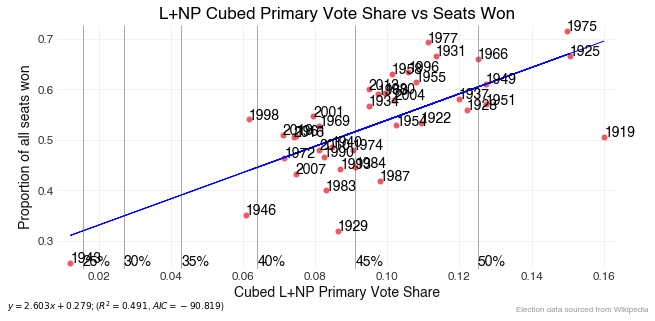

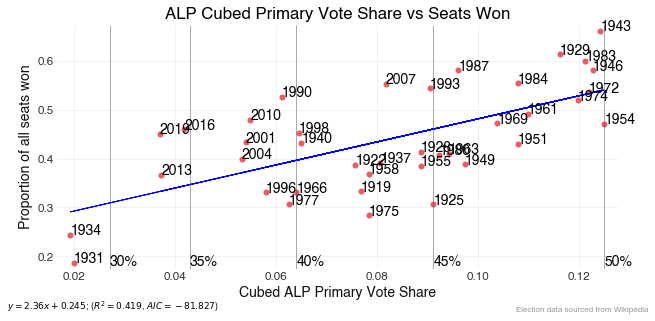

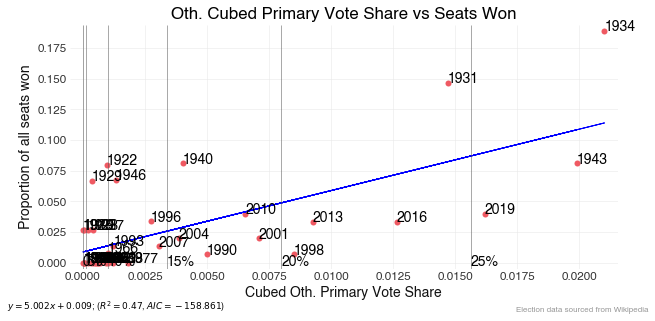

In [10]:
rdf = get_recent_data()
ylabel = 'Proportion of all seats won'
for party in ('L+NP', 'ALP', 'Oth.'):

    seats_won_share = rdf[('Seats', party)] / rdf[('Seats', 'Total')]
    cubed_vote_share = rdf[('Primary vote', party)] ** 3
    title = f'{party} Cubed Primary Vote Share vs Seats Won'
    xlabel = f'Cubed {party} Primary Vote Share'
    plot_results(seats_won_share, cubed_vote_share, title, xlabel, ylabel)

## Cube rule and 2pp vs seats won by major parties only (ie. ignoring other seats won)

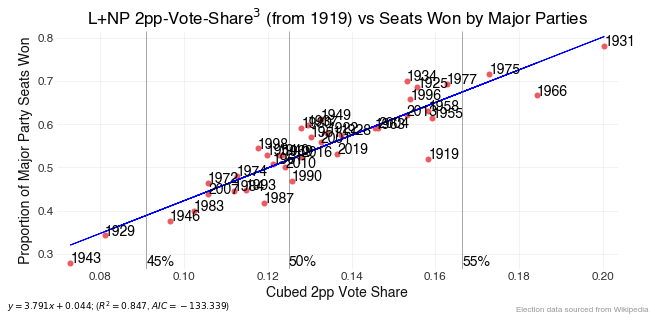

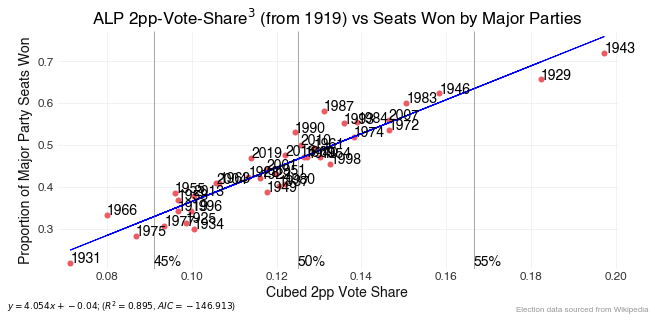

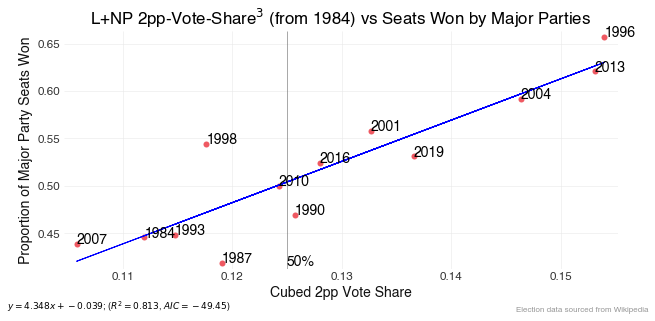

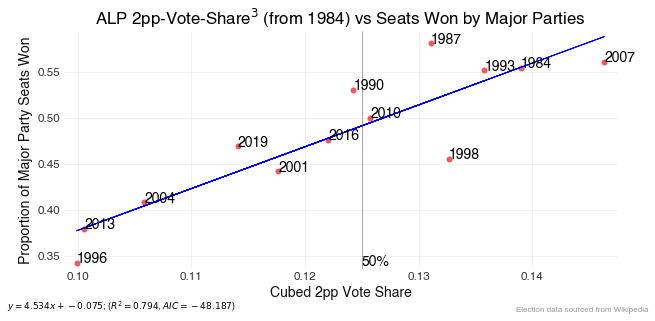

In [11]:
parties = ['L+NP', 'ALP']
rdf = get_recent_data()
ylabel = 'Proportion of Major Party Seats Won'
xlabel = 'Cubed 2pp Vote Share'

for year in ['1919', '1984']:
    rdf = get_recent_data(year)
    for party in parties:
        seats_won_share = rdf[('Seats', party)] / ( rdf[('Seats', 'Total')] - rdf[('Seats', 'Oth.')])
        cubed_vote_share = rdf[('2PP vote', party)] ** 3
        title = f'{party} 2pp-Vote-Share$^3$ (from {year}) vs Seats Won by Major Parties'
        plot_results(seats_won_share, cubed_vote_share, title, xlabel, ylabel)

## 2pp margin vs seat margin

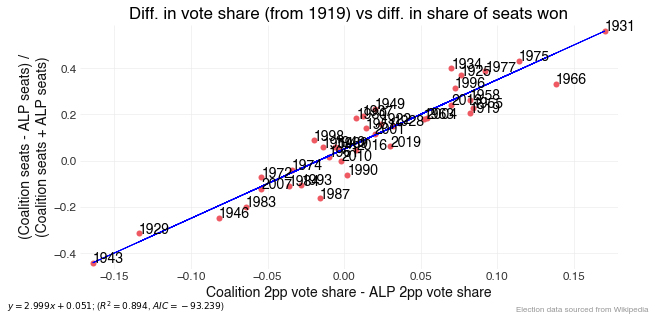

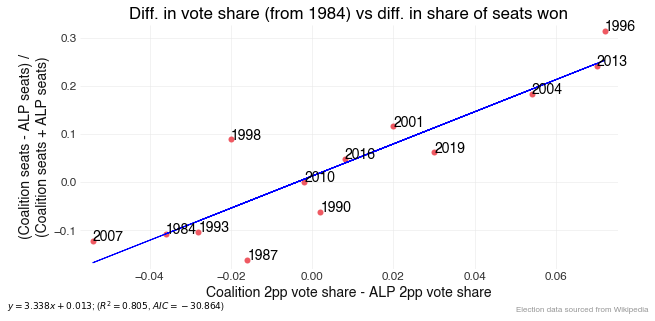

In [12]:
for year in ['1919', '1984']:
    rdf = get_recent_data(year)
    seat_diff = (
        (rdf[('Seats', 'L+NP')] - rdf[('Seats', 'ALP')]) 
        / (rdf[('Seats', 'L+NP')] + rdf[('Seats', 'ALP')])
    )
    party_diff = rdf[('2PP vote', 'L+NP')] - rdf[('2PP vote', 'ALP')]

    title = f'Diff. in vote share (from {year}) vs diff. in share of seats won'
    xlabel = 'Coalition 2pp vote share - ALP 2pp vote share'
    ylabel = '(Coalition seats - ALP seats) /\n(Coalition seats + ALP seats)'
    plot_results(seat_diff, party_diff, title, xlabel, ylabel, False)